In [1]:
import json
import pandas as pd
import numpy as np

In [2]:
time = []
flow = []
tot_1 = []
tot_2 = []
analog_2 = []
with open('B1586024706369.json') as file:
    data = json.load(file)
    for i in np.arange(0,len(data)-1): 
        time.append(data[i]['timeStamp'])
        flow.append(data[i]['idflowmeter'])
        tot_1.append(data[i]['tot1'])
        tot_2.append(data[i]['tot2'])
        analog_2.append(data[i]['analog2'])

In [3]:
flows_data = pd.DataFrame(
    {'Times': time,
     'Total_1' : tot_1,
     'Total_2'  : tot_2,
     'Analog_2' : analog_2
    })

In [4]:
import matplotlib.pyplot as plt

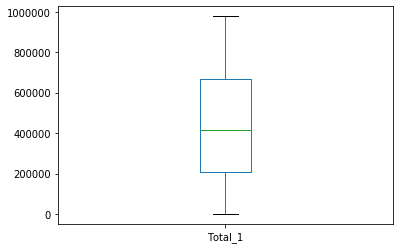

In [5]:
flows_data['Total_1'].plot(kind='box')
plt.show()

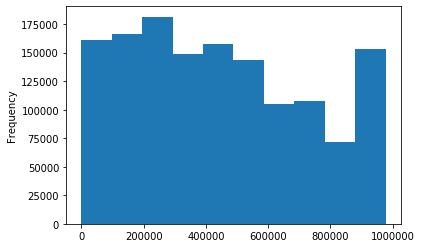

In [6]:
flows_data['Total_1'].plot(kind='hist')
plt.show()

In [7]:
value_t = []

I = range(0, len(flows_data['Total_1'])-1)

for i in I:
    value_t.append(flows_data['Total_1'][i+1]-flows_data['Total_1'][i])

In [8]:
flows_kmeans = pd.DataFrame({
    'Number of samples' : np.arange(0,len(value_t)),
    'Value at time t' : value_t
})

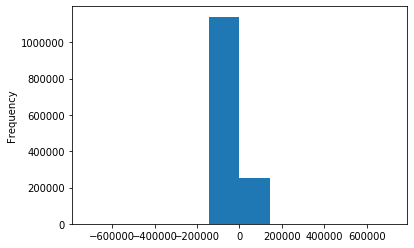

In [9]:
flows_kmeans['Value at time t'].plot(kind='hist')

In [10]:
print('Minimum value ' + str(flows_kmeans['Value at time t'].min()))
print('Maximum value ' + str(flows_kmeans['Value at time t'].max()))

Minimum value -716574.25
Maximum value 716578.31


In [11]:
# Convert the flow values to a numpy array
flows_raw = flows_kmeans['Value at time t'].values

In [12]:
# For compatibility with scipy implementation
flows_raw = flows_raw.reshape(-1, 1)
flows_raw = flows_raw.astype('float64')

In [13]:
from sklearn.cluster import KMeans

In [14]:
distortions = []
K = range(1,10)
for k in K:
    kMeanModel = KMeans(n_clusters = k)
    kMeanModel.fit(flows_raw)
    distortions.append(kMeanModel.inertia_)

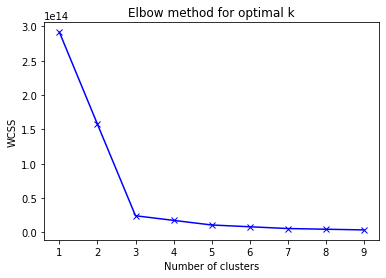

In [15]:
plt.plot(K, distortions, 'bx-')
plt.title('Elbow method for optimal k')
plt.savefig('ElbowMethod.jpg')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [16]:
from scipy.cluster.vq import kmeans, vq

In [17]:
centroids, avg_distance = kmeans(flows_raw, 3)

In [18]:
groups, cdist = vq(flows_raw, centroids)

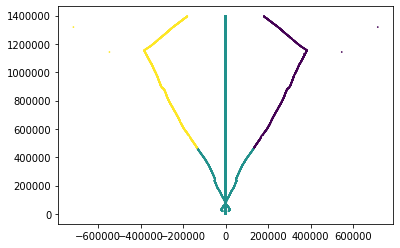

In [20]:
plt.scatter(flows_raw, np.arange(0,len(flows_raw)), c=groups, s=0.5)

In [21]:
from sklearn.ensemble import IsolationForest
rs=np.random.RandomState(0)
clf = IsolationForest(max_samples=100,random_state=rs, contamination=.1) 
clf.fit(flows_kmeans)
if_scores = clf.decision_function(flows_kmeans)
if_anomalies=clf.predict(flows_kmeans)
if_anomalies=pd.Series(if_anomalies).replace([-1,1],[1,0])
if_anomalies=flows_kmeans[if_anomalies==1]

(array([   535.,  13089.,  19759.,  49159.,  80040., 128724., 179668.,
        284401., 397512., 242856.]),
 array([-0.12041743, -0.09499197, -0.06956652, -0.04414107, -0.01871562,
         0.00670983,  0.03213528,  0.05756074,  0.08298619,  0.10841164,
         0.13383709]),
 <a list of 10 Patch objects>)

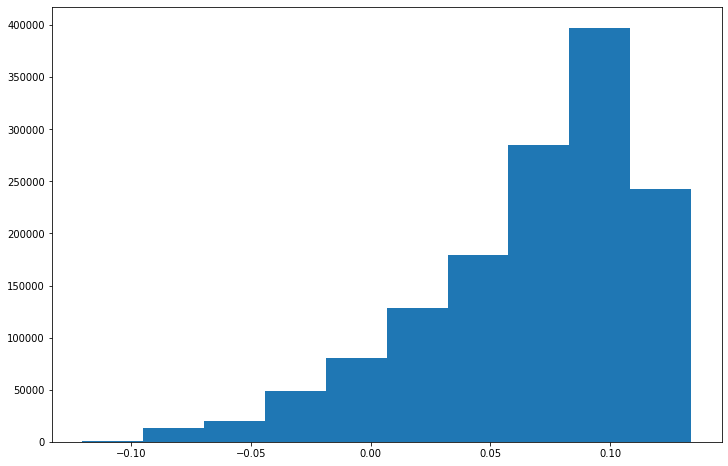

In [22]:
plt.figure(figsize=(12,8))
plt.hist(if_scores)

In [23]:
clf.fit_predict(flows_kmeans)

array([-1, -1, -1, ...,  1,  1,  1])

In [31]:
np.where(clf.fit_predict(flows_kmeans) == 1)

(array([    138,     139,     140, ..., 1395740, 1395741, 1395742],
       dtype=int64),)

In [32]:
np.where(clf.fit_predict(flows_kmeans) == -1)

(array([      0,       1,       2, ..., 1395681, 1395689, 1395698],
       dtype=int64),)

In [26]:
toRemove = np.where(clf.fit_predict(flows_kmeans) == -1)